In [2]:
# imports
import keras 
import cv2 # opencv
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import color, feature
import skimage.data
import pandas as pd
import numpy as np
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
image_base_path = '../../images/'
audio_base_path = '../../audio/'
video_path = '../../ground_truth/Muppets-02-01-01/'
label_file = '../../ground_truth/Muppets-02-01-01/Muppets-02-01-01.txt'
evaluation_base_path = '../../evaluation/'

In [9]:
# capture the videos and extract frames
for video_path in glob.glob(video_file_glob_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    image_folder_path = image_base_path + os.path.basename(video_path).split('.')[0]
    Path(image_folder_path).mkdir(parents=True, exist_ok=True)
    
    while(cap.isOpened()):
        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        if not ret:
            print('Failed to read frame %d of video %r.', frame_id, video_path)
            break
            
        filename = image_folder_path + '/frame%d.jpg' % frame_id
        cv2.imwrite(filename, frame)
        
        if frame_id == 300:
            break

In [12]:
# extract audio from avi video
Path(audio_base_path).mkdir(parents=True, exist_ok=True)
for video_path in glob.glob(video_file_glob_path):
    video = VideoFileClip(video_path)
    filename = audio_base_path + os.path.basename(os.path.normpath(video_path)).split('.')[0] + '.wav'
    if not os.path.isfile(filename):
        video.audio.write_audiofile(filename)
    video.close()

chunk:   0%|                                                               | 3/34118 [00:00<21:58, 25.87it/s, now=None]

MoviePy - Writing audio in ../../audio/Muppets-02-01-01.wav


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file ../../audio/Muppets-02-01-01.wav:

b'../../audio/Muppets-02-01-01.wav: Permission denied\r\n'

In case it helps, make sure you are using a recent version of FFMPEG (the versions in the Ubuntu/Debian repos are deprecated).

In [10]:
# this section hold useful helper functions and transformers

# method for image resizing and extracting vector of raw values
def extract_value_vector(image, size=(128, 128)):
    return cv2.resize(image, size).flatten()

def extract_colour_histogram(image, bins=(32, 32, 32)):
    # convert image to hsv space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # extract color histogram from image and take all 3 channels into account
    color_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # normalize resulting histogram
    cv2.normalize(color_hist, color_hist)
    
    # print resulting historgram
    # plt.hist(image.ravel(),256,[0,256])
    # cols = ('b', 'g', 'r')
    # for i, col in enumerate(cols):
    #     histr = cv2.calcHist([image],[i],None,[256],[0,256])
    #     plt.plot(histr,color = col)
    #     plt.xlim([0,256])
    # plt.show()
    
    # return histogram as feature vector
    return color_hist.flatten()

def print_data_distribution(df):
    kermits = sum(df['kermit'])
    waldorf_statlers = sum(df['waldorf_and_statler'])
    pigs = sum(df['pig'])
    swedish_chefs = sum(df['swedish_chef'])
    nones = len(df) - (kermits + waldorf_statlers + pigs + swedish_chefs)
    
    print('Dataset statistics:')
    print('Kermit:\t\t\t' + str(kermits))
    print('Waldorf/Statler:\t' + str(waldorf_statlers))
    print('Pigs:\t\t\t' + str(pigs))
    print('Swedish Chef:\t\t' + str(swedish_chefs))
    print('None:\t\t\t' + str(nones))
    print('Total:\t\t\t' + str(len(df)))

def print_measures(model, x_test, y_test, y_pred):
    print('[INFO] Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=0, labels=[0, 1]))
    print('[INFO] Confusion Matrix:')
    plot_confusion_matrix(model, x_test, y_test, values_format='d')
    plt.show()
    plot_roc_curve(model, x_test, y_test)
    plt.show()


In [7]:
label_map = {0: 'kermit_the_frog',
                 1: 'waldorf_and_statler',
                 2: 'pig',
                 3: 'swedish_chef',
                 4: 'none'}

data = pd.DataFrame([], columns=['name', 'filename', 'kermit', 'waldorf_and_statler', 'pig', 'swedish_chef'])

with open(label_file) as file:
    lines = file.readlines()
    
for line in lines:
    splits = list(map(lambda line: line.strip(), line.split(",")))
    name = splits[0]
    labels = [int(splits[i]) for i in range(1, len(splits)) if int(splits[i]) != 4]
        
    filename = glob.glob(video_path + name + "_*")[0]
    data = data.append({'name': name,
                        'filename': filename,
                        'kermit': 1 if 0 in labels else 0,
                        'waldorf_and_statler': 1 if 1 in labels else 0,
                        'pig': 1 if 2 in labels else 0,
                        'swedish_chef': 1 if 3 in labels else 0}, ignore_index=True)

#data.to_csv("data.csv")
print_data_distribution(data)
    

Dataset statistics:
Kermit:			432
Waldorf/Statler:	150
Pigs:			119
Swedish Chef:		140
None:			2383
Total:			3224


In [8]:
## Preprocessing and splitting data for Kermit
df1 = data.copy()

# init data structures for feature vectors, image pixel values and labels
hist_features = []
images_raw_pixels = []
labels = df1['kermit'].tolist()
indices = df1['name'].tolist()

print('[INFO] start preprocessing images (color histogram)')

counter = 1
# iterate over all provided images and extract features, labels and image pixels
for idx, row in df1.iterrows():
    img = cv2.imread(row['filename'])
    
    # extract color distribution of the image
    img_color_hist = extract_colour_histogram(img)
    
    # extract raw pixels of the image
    img_pixels = extract_value_vector(img)

    hist_features.append(img_color_hist)
    images_raw_pixels.append(img_pixels)
    
    # show process
    if counter % 200 == 0:
        print('[INFO] images preprocessed %d/%d' % (counter, len(df1)))
    counter += 1

# split data into training and test sets for raw pixel data
x_train_raw, x_test_raw, y_train_raw, y_test_raw, x_idx_raw, y_idx_raw = train_test_split(images_raw_pixels, labels, indices, test_size=0.3)

# split data into training and test sets for histogram features
x_train_hist, x_test_hist, y_train_hist, y_test_hist, x_idx_hist, y_idx_hist = train_test_split(hist_features, labels, indices, test_size=0.3)

[INFO] start preprocessing images (color histogram)
[INFO] images preprocessed 200/3224
[INFO] images preprocessed 400/3224
[INFO] images preprocessed 600/3224
[INFO] images preprocessed 800/3224
[INFO] images preprocessed 1000/3224
[INFO] images preprocessed 1200/3224
[INFO] images preprocessed 1400/3224
[INFO] images preprocessed 1600/3224
[INFO] images preprocessed 1800/3224
[INFO] images preprocessed 2000/3224
[INFO] images preprocessed 2200/3224
[INFO] images preprocessed 2400/3224
[INFO] images preprocessed 2600/3224
[INFO] images preprocessed 2800/3224
[INFO] images preprocessed 3000/3224
[INFO] images preprocessed 3200/3224


[INFO] Start training and evaluating classifier for Kermit the frog
[INFO] Train KNN model for raw pixels
[INFO] KNN hyperparameter: k=20
[INFO] Predict test data for raw pixels
[INFO] Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       834
           1       0.89      0.87      0.88       134

    accuracy                           0.97       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.97      0.97      0.97       968

[INFO] Confusion Matrix:


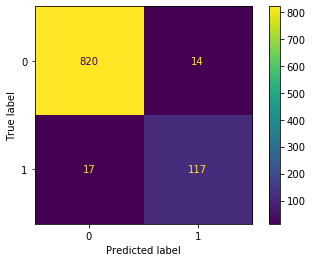

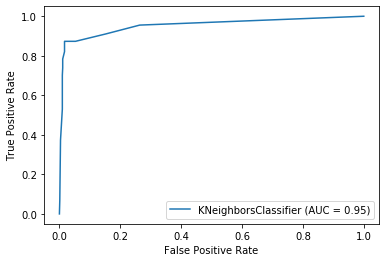

[INFO] Train KNN model for color histogram features
[INFO] KNN hyperparameter: k=20
[INFO] Predict test data for color histogram
[INFO] Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       827
           1       0.87      0.84      0.85       141

    accuracy                           0.96       968
   macro avg       0.92      0.91      0.91       968
weighted avg       0.96      0.96      0.96       968

[INFO] Confusion Matrix:


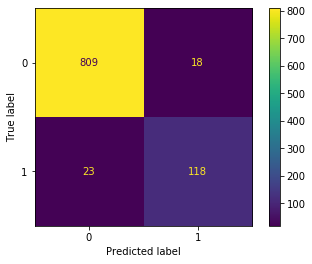

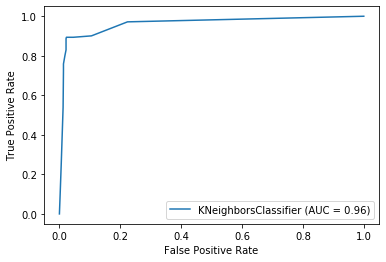

In [11]:
# Classifiers for Kermit
# variables for classifier configuration
k = 20

print('[INFO] Start training and evaluating classifier for Kermit the frog')

# train a KNN classifier on raw pixel data
print('[INFO] Train KNN model for raw pixels')
print('[INFO] KNN hyperparameter: k=%d' % k)
model_raw = KNeighborsClassifier(n_neighbors=k)
model_raw.fit(x_train_raw, y_train_raw)
print('[INFO] Predict test data for raw pixels')
y_pred_raw = model_raw.predict(x_test_raw)
print_measures(model_raw, x_test_raw, y_test_raw, y_pred_raw)


# train a KNN classifier on histogram features
print('[INFO] Train KNN model for color histogram features')
print('[INFO] KNN hyperparameter: k=%d' % k)
model_hist = KNeighborsClassifier(n_neighbors=k)
model_hist.fit(x_train_hist, y_train_hist)
print('[INFO] Predict test data for color histogram')
y_pred_hist = model_hist.predict(x_test_hist)
print_measures(model_hist, x_test_hist, y_test_hist, y_pred_hist)


In [10]:
## Identifying Waldorf/Statler
data

,name,filename,kermit,waldorf_and_statler,pig,swedish_chef
0,1,../../ground_truth/Muppets-02-01-01\10000_0.png,0,0,0,0
1,14,../../ground_truth/Muppets-02-01-01\14008_4.png,0,0,0,0
2,26,../../ground_truth/Muppets-02-01-01\26008_4.png,0,0,0,0
3,38,../../ground_truth/Muppets-02-01-01\38008_4.png,0,0,0,0
4,50,../../ground_truth/Muppets-02-01-01\5008_4.png,0,0,0,0
...,...,...,...,...,...,...
3219,38632,../../ground_truth/Muppets-02-01-01\38632_4.png,0,0,0,0
3220,38644,../../ground_truth/Muppets-02-01-01\38644_4.png,0,0,0,0
3221,38656,../../ground_truth/Muppets-02-01-01\38656_4.png,0,0,0,0
3222,38668,../../ground_truth/Muppets-02-01-01\38668_4.png,0,0,0,0
